# Task 3: Sales Forecasting Using Time Series Analysis

**Task Overview**\
**Objective:** Forecast the next 12 months of product sales using time series models.

**Deliverables:**

- Time series decomposition (trend, seasonality)
- ARIMA, Prophet or LSTM modeling
- Evaluation metrics (MAE, RMSE)
- Forecast visualizations

**Mock Data (Python):**

import pandas as pd\
import numpy as np\
date_range = pd.date_range(start='2020-01-01', periods=36, freq='M')\
sales = np.random.poisson(lam=200, size=36) + np.linspace(0, 100, 36)\
df = pd.DataFrame({'Date': date_range, 'Sales': sales.round(2)})\

# 1. Setup and Data Generation

- First we'll setup an environment and create mock dataset.
- This data simulates 36 months of sales with an underlying trend, which is common in real-world scenarios.

## 1.1 Generating Mock Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# setting random seed to get same results everytime
np.random.seed(42)

# generating mock data
# creating date range for 36 months (3 years)
date_range = pd.date_range(start="2020-01-01", periods=36, freq="ME")

# generate sales data with a poisson distribution and add a linear trend
sales = np.random.poisson(lam=200, size=36) + np.linspace(0, 100, 36)

# Create DataFrame
df = pd.DataFrame({"Date" : date_range, "Sales" : sales.round(2)})

# Set Date as DataFrame Index, which is required for most time series libraries
df.set_index("Date", inplace=True)


In [2]:
# displaying data
df.head()

,Sales
Date,
2020-01-31,195.00
2020-02-29,212.86
2020-03-31,189.71
2020-04-30,212.57
2020-05-31,227.43


## 1.1 Visualize Historial Sales Data

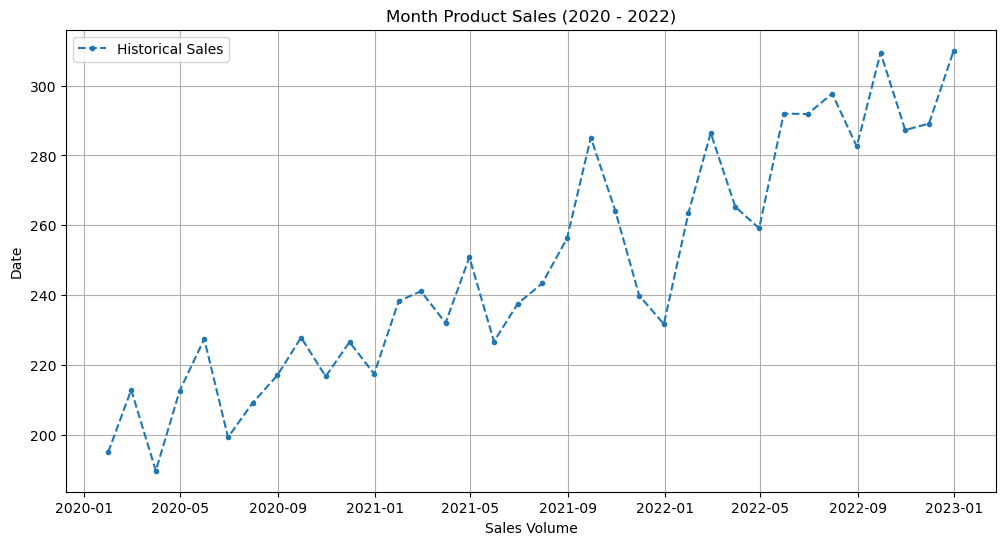

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Sales"], marker=".", linestyle="--", label="Historical Sales")
plt.title("Month Product Sales (2020 - 2022)")
plt.xlabel("Sales Volume")
plt.ylabel("Date")
plt.grid(True)
plt.legend()
plt.show()

# 2. Time Series Decomposition

Decomposition is a critical step to understand the underlying structure of time series data. It breaks the data into three components:
- **Trend:** The long-term progression of series (e.g., sales increasing over time).
- **Seasonality:** Repeating patterns or cycles (e.g., higher sales every December).
- **Residual:** The random, irregular components left over after removing the trend and seasonality.

We'll use the `season_decompose` function from the `statemodels` library for this.

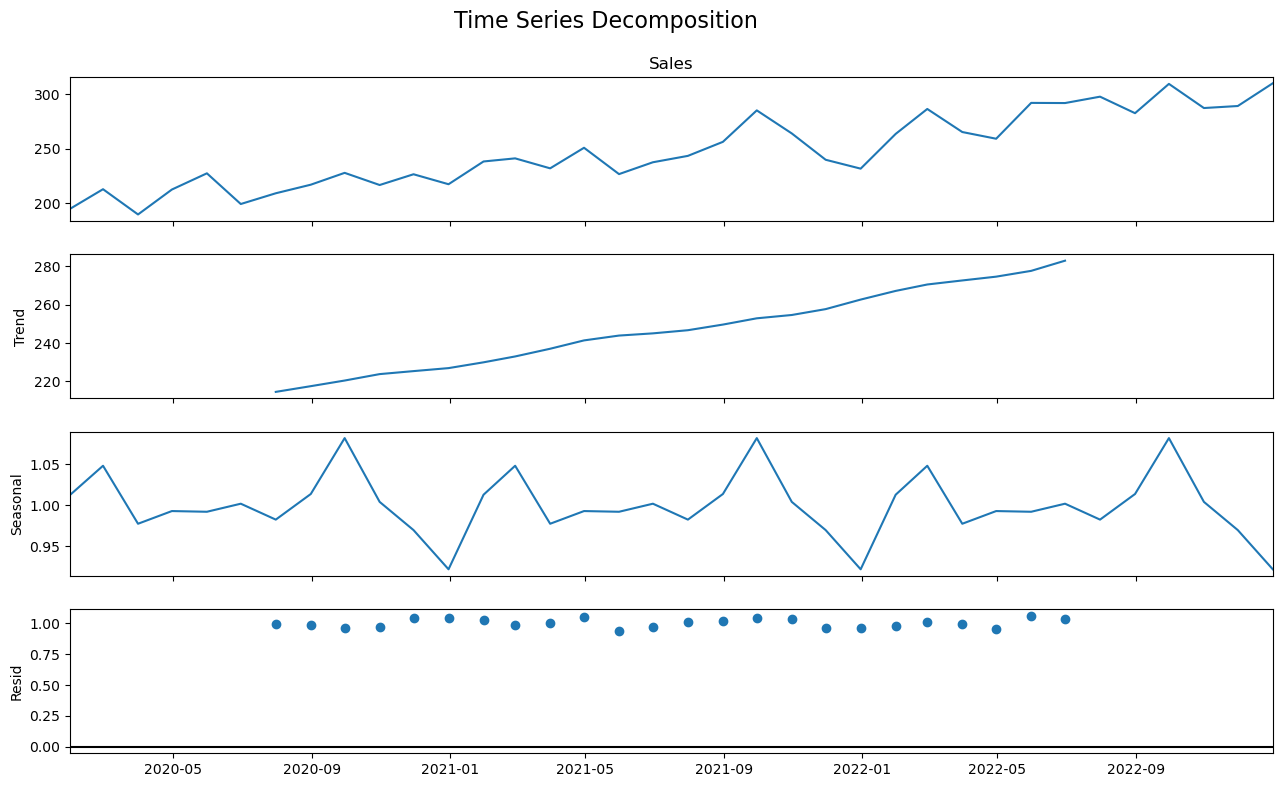

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series. We assume the 12 month seasonal cycle.
# A multiplicative model is often suitable when variance of the series change over time.
decomposition = seasonal_decompose(x=df["Sales"], model="multiplicative", period=12)


# Visualize the decompose components
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.suptitle("Time Series Decomposition", y=1.01, fontsize=16)
plt.show()

**Observation:**
- **Trend:** Trend is positively upward.
- **Seasonality:** Seasonality can clearly be seen that, each year sales repeat monthly in the same manor.
- **Residual:** Residual appears to be random, which is what we wanted to see.

# 3. Modeling with SARIMA

For this task, the **SARIMA (Seasonal AutoRegressive Integratd Moving Average)** model is an excellent choice because it inherently handles seasonality, which is present in our data.

## 3.1 Train/Test Split

To evaluate our model's performance, we'll train our model on first two years of data and hold out the last year as a "test" set to check accuracy of our forecasts.

In [5]:
# Split data into training (first 24 months) and testing (last 12 months) sets
train_data = df.iloc[:-12]
test_data = df.iloc[-12:]

print(f"Training data points: {len(train_data)}")
print(f"Testing data points: {len(test_data)}")

Training data points: 24
Testing data points: 12


## 3.2 Building and Training the Model

We'll use `pmdarima` library's `auto_arima` function. This powerful tool automatically searches for the optimal SARIMA model parameters, saving us from manual and time-consuming seleciton process.

In [6]:
import pmdarima as pm

# Automatically find the best SARIMA model
# auto_arima will search for the best (p,d,q) and seasonal (P, D, Q, m) parameters.
# m=12 indicates a yearly seasonal pattern.
sarima_model = pm.auto_arima(
    y=train_data["Sales"],   
    seasonal=True,          # Enable seasonal modeling
    m=12,                   # The period for seasonal differencing
    D = 1,                  # Forcing function to don't figure out D, as we have little data, and proceed with find the other optimal parameters
    suppress_warnings=True, 
    stepwise=True,          # Use a stepwise algorithm to find best model faster
    trace=True              # Print status of the model search
)

print("-"*25, "Best Model Summary", "-"*25)
print(sarima_model.summary())

d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\d

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=114.708, Time=1.88 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=104.237, Time=0.05 sec


d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=0.82 sec


d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=122.408, Time=0.05 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=106.237, Time=0.07 sec


d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=106.236, Time=0.45 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=108.237, Time=0.09 sec


d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=106.177, Time=0.28 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=106.097, Time=0.11 sec


d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.27 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 4.744 seconds
------------------------- Best Model Summary -------------------------
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   24
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                 -50.118
Date:                  Fri, 13 Jun 2025   AIC                            104.237
Time:                          09:22:34   BIC                            105.206
Sample:                      01-31-2020   HQIC                           103.878
                           - 12-31-2021                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

**Observations:**
<table border="1" cellpadding="8" cellspacing="0">
  <thead>
    <tr>
      <th>Test</th>
      <th>Value</th>
      <th>Prob</th>
      <th>What it Means (Good signs are in <b>bold</b>)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>Ljung-Box (Q)</b></td>
      <td>0.07</td>
      <td>0.79</td>
      <td>Tests for patterns in the errors. We want <b>Prob(Q) &gt; 0.05</b>. Ours is <b>0.79</b>, which is <b>excellent</b>. It means no leftover patterns were found.</td>
    </tr>
    <tr>
      <td><b>Jarque-Bera (JB)</b></td>
      <td>1.02</td>
      <td>0.60</td>
      <td>Tests if the errors are normally distributed. We want <b>Prob(JB) &gt; 0.05</b>. Ours is <b>0.60</b>, which is <b>great</b>.</td>
    </tr>
    <tr>
      <td><b>Heteroskedasticity (H)</b></td>
      <td>6.27</td>
      <td>0.10</td>
      <td>Tests if the error variance is constant. We want <b>Prob(H) &gt; 0.05</b>. Ours is <b>0.10</b>, which is <b>good</b>.</td>
    </tr>
  </tbody>
</table>

**Conclusion:** The model has been successfully trained, and the diagnostic tests confirm it's a statistically sound fit for the data. This means I have a reliable model and can now confidently move on to the forecasting and evaluation steps.

# 4. Forecasting and Visualization

With our model trained, we can now use it to forecast sales for the next 12 months.

## 4.1 Forcasting

In [7]:
# Generate forecasts
# We'll forecast 24 months ahead: 12 months to validate against the test set, and 12 for the future.
n_periods = 24
forecast, conf_int = sarima_model.predict(n_periods=n_periods, return_conf_int=True)

d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AWFERA\Skilled Score\Data Science Internship\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## 4.2 Visualization

C:\Users\nasir\AppData\Local\Temp\ipykernel_1308\523678233.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=test_data.index[0], periods=n_periods,  freq="M")


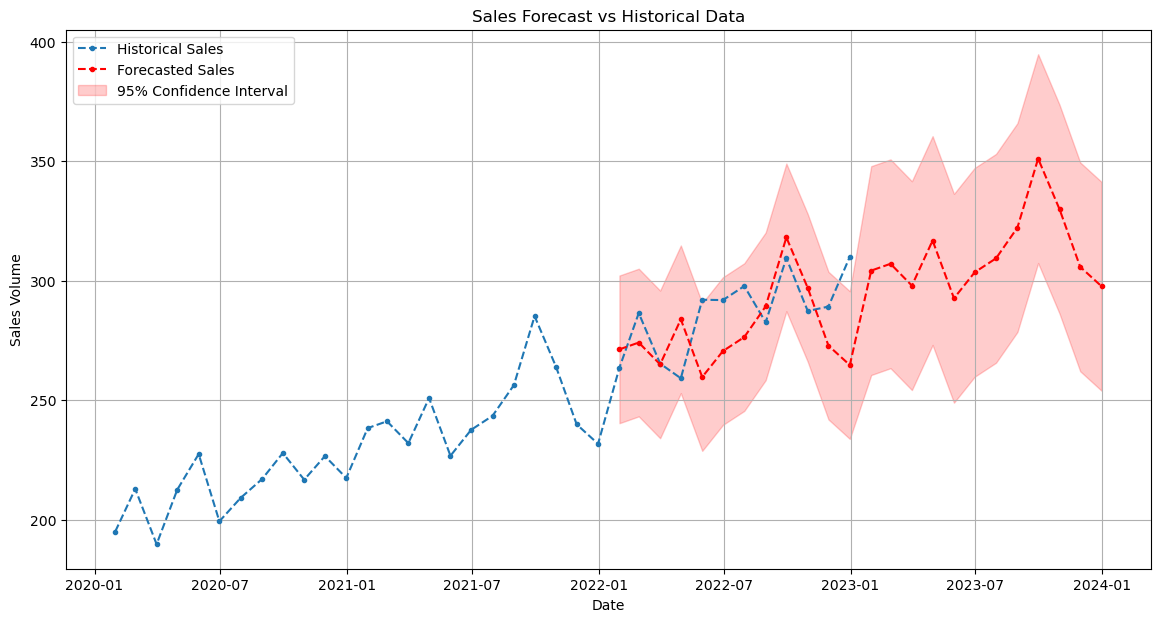

In [8]:
# Create a date range for the forecasted period
forecast_dates = pd.date_range(start=test_data.index[0], periods=n_periods,  freq="M")

# Visualiza Forecast vs Historical Data
plt.figure(figsize=(14, 7))

# plotting historical data 
plt.plot(df.index, df["Sales"], marker=".", linestyle="--", label="Historical Sales")

# plot the forecast
plt.plot(forecast_dates, forecast, color="red", marker=".", linestyle="--", label="Forecasted Sales")

# plot the confidence interval
plt.fill_between(
    forecast_dates,
    conf_int[:,0],
    conf_int[:,1],
    color="red", alpha=0.2, label="95% Confidence Interval"
)
plt.title("Sales Forecast vs Historical Data")
plt.xlabel("Date")
plt.ylabel("Sales Volume")
plt.legend()
plt.grid(True)
plt.show()

# 5. Model Evaluation
Finally, we'll quantitatively measure the model's performance on the test set using two standard regression metrics:
- **Mean Absolute Error (MAE):** The average absolute difference between the predicted and actual values.
- **Root Mean Squared Error:** The square root of the average of squared difference. It penalized the larger error more heavily.


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract the forecasts that correspond to the test data period
validation_forecast = forecast[:12]

# Calculate Evaluation Metrics
mae = mean_absolute_error(test_data["Sales"], validation_forecast)
rmse = np.sqrt(mean_squared_error(test_data["Sales"], validation_forecast))

print("-"*25 ,"Model Evaluation on the Test Set", "-"*25)
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# Comparison Table of Actual and Forecasted Sales

comparison_df = pd.DataFrame({
    "Actual_Sales" : test_data["Sales"],
    "Predicted_Sales" : validation_forecast,
    "Sales_Difference" : test_data["Sales"] - validation_forecast
})

print("\nActual vs Predicted Sales (Test Set)")
comparison_df


------------------------- Model Evaluation on the Test Set -------------------------
Mean Absolute Error: 17.22
Root Mean Squared Error: 21.04

Actual vs Predicted Sales (Test Set)


,Actual_Sales,Predicted_Sales,Sales_Difference
2022-01-31,263.57,271.2425,-7.6725
2022-02-28,286.43,274.0925,12.3375
2022-03-31,265.29,264.9525,0.3375
2022-04-30,259.14,283.8125,-24.6725
2022-05-31,292.00,259.6625,32.3375
2022-06-30,291.86,270.5225,21.3375
2022-07-31,297.71,276.3825,21.3275
2022-08-31,282.57,289.2425,-6.6725
2022-09-30,309.43,318.0925,-8.6625
2022-10-31,287.29,296.9525,-9.6625


### 📋 My Sales Forecast Model Evaluation Summary

| **Category**             | **Details**                                                                 |
|--------------------------|------------------------------------------------------------------------------|
| **Model Type**           | I used a SARIMA model                                                       |
| **Forecast Horizon**     | I forecasted 12 months ahead (the test set)                                 |
| **Mean Absolute Error (MAE)**  | 17.22 — On average, my model’s predictions were off by about 17 units        |
| **Root Mean Squared Error (RMSE)** | 21.04 — This reflects the typical magnitude of prediction errors, with more weight on larger errors |
| **Sales Range**          | Sales typically ranged from about 260 to 310 units                          |
| **Most Accurate Months** | March, August, September, and October had errors within ±10 units           |
| **Largest Errors**       | April (-24.67), May (+32.34), July (+21.33), and December (+45.34)          |
| **Systematic Issues**    | The model tended to under-predict during high sales months (May–July, Nov–Dec) |
| **Model Strengths**      | It tracked the overall trend well and was accurate for most average months  |
| **Model Weaknesses**     | It missed some seasonal peaks, especially in the year-end months            |
